In [1]:
import sys
import numpy as np
import pandas as pd
from tqdm import tqdm 

import matplotlib.pyplot as plt
import seaborn as sns

path_to_quant = '//home/gridsan/djuna/homer/github/confocalQuant/'
sys.path.append(path_to_quant)

from confocalQuant.segmentation import load_3D, impose_segmentations, int_to_float, run_med_filter, bgrnd_subtract, get_anisotropy, do_inference, sigmoid, gamma_correct_image, get_czi_files, extract_channels, impose_segmentation, float_to_int, hide_masks, impose_segmentation_all
from confocalQuant.stats import get_expectations, compute_nested_anova
from confocalQuant.qc import return_channel_moments_per_im, get_day_and_time, get_metadata
from confocalQuant.plotting import plot_hist, plot_treatments, plot_lines, plot_scatter
from confocalQuant.image import save_mean_proj, add_inset, plot_axis, get_rep_im, add_scale_bar, get_mean_projections
from confocalQuant.data_handling import get_id_data, print_readme, print_failed_jobs, return_results,get_out_files,is_string_present, return_non_unique_indices, print_metadata, compute_avs, extract_sbatch_parameters
from confocalQuant.widgets import toggle_filters

/home/gridsan/djuna/.local/lib/python3.8/site-packages/pydantic/_migration.py:281: UserWarning: `pydantic.error_wrappers:ValidationError` has been moved to `pydantic:ValidationError`.
  warnings.warn(f'`{import_path}` has been moved to `{new_location}`.')


In [ ]:
### batch 0131 - looks ok 
### batch 0221 - looks ok

### batch 0207 - bad neurons
### batch 0214 - doesn't look so good either 

#### 1. Toggle segmentations

In [2]:
out_parent = '../new_outs//iNbatch02212024_PLIN2_Lipidspot_out/'
in_parent = '../new_data/iNbatch02212024_PLIN2_Lipidspot/'

In [41]:
files = get_czi_files(in_parent)
len(files)

96

In [62]:
#print_readme(in_parent + 'readme.txt')

In [4]:
print_failed_jobs(out_parent)

In [5]:
all_mat, all_masks, Nzi_per_job, cells_per_job, zi_per_job, probs, randID_per_job = return_results(out_parent+'out.sbatch', '.')

In [65]:
segs = impose_segmentations(zi_per_job, Nzi_per_job, all_mat, all_masks, val=.5, files=files)

100%|██████████| 96/96 [03:27<00:00,  2.16s/it]


In [66]:
toggle_filters(files, in_parent, [3,2,0,1], segs)

#### 2. Compute intensities

In [220]:
l, p = return_percentiles_all_images(files, zi_per_job, Nzi_per_job, all_masks, all_mat, out_float_sele)
LS_thresh = np.percentile(l, 99)
PLIN_thresh = np.percentile(p, 99)

  6%|▋         | 6/96 [01:11<17:49, 11.88s/it]


KeyboardInterrupt: 

In [ ]:
print('PLIN 99 percentile: '+str(PLIN_thresh))
print('Lipidspot 99 percentile: '+str(LS_thresh))

In [221]:
lines, treat = get_meta_vectors(in_parent, files)
channels = [0,1,2,3]
thresh = [0, 0, 0.29, 0.11]
channel_names = ['DAPI', 'NeuN', 'Lipidspot', 'PLIN2']
resV, resN, resE, resF = compute_intensities(channels, channel_names, files, zi_per_job, Nzi_per_job, probs, all_masks, all_mat, lines, treat, thresh)

100%|██████████| 96/96 [09:02<00:00,  5.65s/it]


In [223]:
resE.to_csv(out_parent+'resE_updated.csv')
resV.to_csv(out_parent+'resV_updated.csv')
resF.to_csv(out_parent+'resF_updated.csv')

In [266]:
resF.head()

,channel_DAPI,channel_NeuN,channel_Lipidspot,channel_PLIN2,ID,file,line,treatment,well,grp
0,0.732558,0.045983,0.0,0.0,0,B03_1.czi,Y622,vehicle,B03_1.czi,B03
1,0.652941,0.050588,0.0,0.0,0,B03_1.czi,Y622,vehicle,B03_1.czi,B03
2,0.563769,0.138911,0.0,0.0,0,B03_1.czi,Y622,vehicle,B03_1.czi,B03
3,0.709393,0.024462,0.0,0.0,0,B03_1.czi,Y622,vehicle,B03_1.czi,B03
4,0.807223,0.037706,0.0,0.0,0,B03_1.czi,Y622,vehicle,B03_1.czi,B03


In [298]:
#plt.scatter(resE['channel_Lipidspot'], resE['channel_PLIN2'])

In [275]:
plin_positive = resF['channel_PLIN2'] > 0

proportion_df = resF.groupby(['line', 'treatment', 'grp']).apply(
    lambda group: plin_positive[group.index].mean()
).reset_index(name='proportion_plin_positive')


In [311]:
plin_positive = (resF['channel_PLIN2'] > 0)

proportion_df = resF.groupby(['line', 'treatment', 'grp']).apply(
    lambda group: plin_positive[group.index].mean()
).reset_index(name='proportion_plin_positive')


<Axes: xlabel='line', ylabel='proportion_plin_positive'>

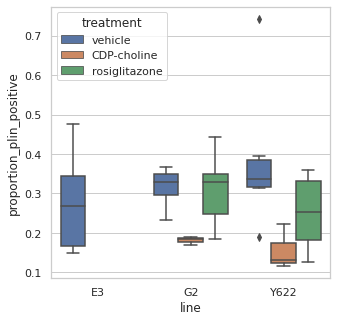

In [312]:
plt.figure(figsize=(5,5))
sns.boxplot(data=proportion_df, x = 'line', y='proportion_plin_positive', hue = 'treatment')

<Axes: xlabel='line', ylabel='proportion_plin_positive'>

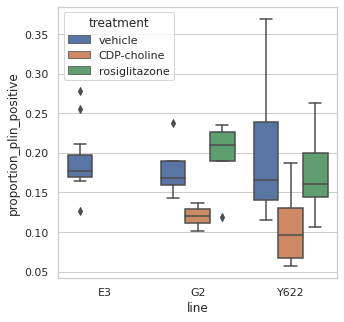

In [322]:
plin_positive = (resF['channel_Lipidspot'] > 0)

proportion_df = resF.groupby(['line', 'treatment', 'grp']).apply(
    lambda group: plin_positive[group.index].mean()
).reset_index(name='proportion_plin_positive')

plt.figure(figsize=(5,5))
sns.boxplot(data=proportion_df, x = 'line', y='proportion_plin_positive', hue = 'treatment')

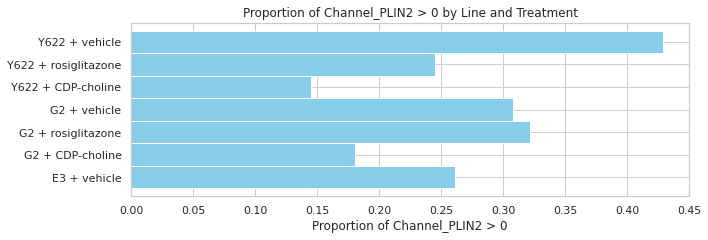

In [314]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

plin_positive = (resF['channel_PLIN2'] > 0)

proportion_df = resF.groupby(['line', 'treatment']).apply(
    lambda group: plin_positive[group.index].mean()
).reset_index(name='proportion_plin_positive')


# Create a new figure and axis for plotting
fig, ax = plt.subplots(figsize=(10, len(proportion_df) * 0.5))

# Plotting each bar with height = 1
for index, row in proportion_df.iterrows():
    ax.barh(index, row['proportion_plin_positive'], height=1, color='skyblue')

# Setting the y-ticks to the combination of 'line' and 'treatment'
ax.set_yticks(np.arange(len(proportion_df)))
ax.set_yticklabels(proportion_df['line'] + ' + ' + proportion_df['treatment'])

# Adding labels and title
ax.set_xlabel('Proportion of Channel_PLIN2 > 0')
ax.set_title('Proportion of Channel_PLIN2 > 0 by Line and Treatment')

plt.tight_layout()
plt.show()


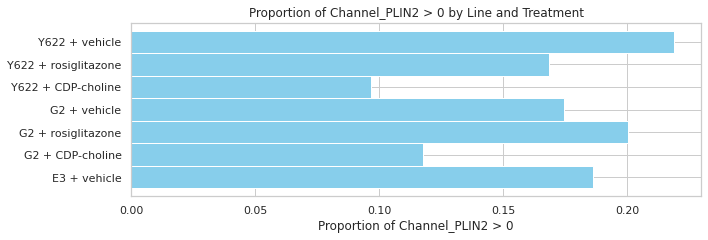

In [315]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

plin_positive = (resF['channel_Lipidspot'] > 0)

proportion_df = resF.groupby(['line', 'treatment']).apply(
    lambda group: plin_positive[group.index].mean()
).reset_index(name='proportion_plin_positive')


# Create a new figure and axis for plotting
fig, ax = plt.subplots(figsize=(10, len(proportion_df) * 0.5))

# Plotting each bar with height = 1
for index, row in proportion_df.iterrows():
    ax.barh(index, row['proportion_plin_positive'], height=1, color='skyblue')

# Setting the y-ticks to the combination of 'line' and 'treatment'
ax.set_yticks(np.arange(len(proportion_df)))
ax.set_yticklabels(proportion_df['line'] + ' + ' + proportion_df['treatment'])

# Adding labels and title
ax.set_xlabel('Proportion of Channel_PLIN2 > 0')
ax.set_title('Proportion of Channel_PLIN2 > 0 by Line and Treatment')

plt.tight_layout()
plt.show()


In [286]:
plin_positive = resF['channel_Lipidspot'] > 0

proportion_df = resF.groupby(['line', 'treatment', 'grp']).apply(
    lambda group: plin_positive[group.index].mean()
).reset_index(name='proportion_plin_positive')


<Axes: xlabel='line', ylabel='proportion_plin_positive'>

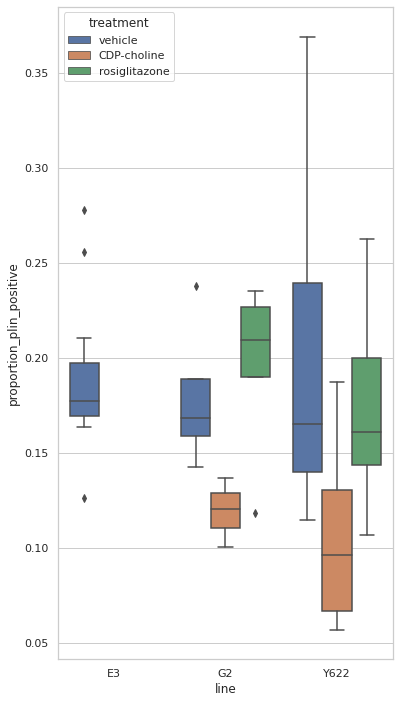

In [287]:
sns.boxplot(data=proportion_df, x = 'line', y='proportion_plin_positive', hue = 'treatment')

In [288]:
plin_positive = resF['channel_Lipidspot'] > 0

proportion_df = resF.groupby(['line', 'treatment']).apply(
    lambda group: plin_positive[group.index].mean()
).reset_index(name='proportion_plin_positive')


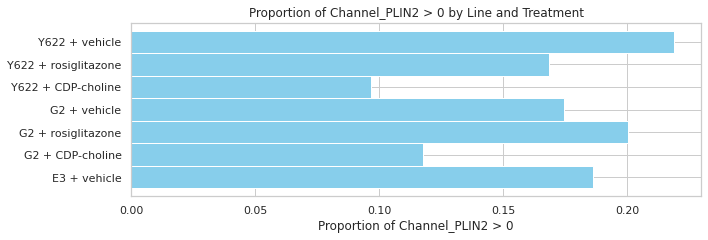

In [289]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Create a new figure and axis for plotting
fig, ax = plt.subplots(figsize=(10, len(proportion_df) * 0.5))

# Plotting each bar with height = 1
for index, row in proportion_df.iterrows():
    ax.barh(index, row['proportion_plin_positive'], height=1, color='skyblue')

# Setting the y-ticks to the combination of 'line' and 'treatment'
ax.set_yticks(np.arange(len(proportion_df)))
ax.set_yticklabels(proportion_df['line'] + ' + ' + proportion_df['treatment'])

# Adding labels and title
ax.set_xlabel('Proportion of Channel_PLIN2 > 0')
ax.set_title('Proportion of Channel_PLIN2 > 0 by Line and Treatment')

plt.tight_layout()
plt.show()


/home/gridsan/djuna/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/gridsan/djuna/.local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/gridsan/djuna/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/gridsan/djuna/.local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/gridsan/djuna/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWar

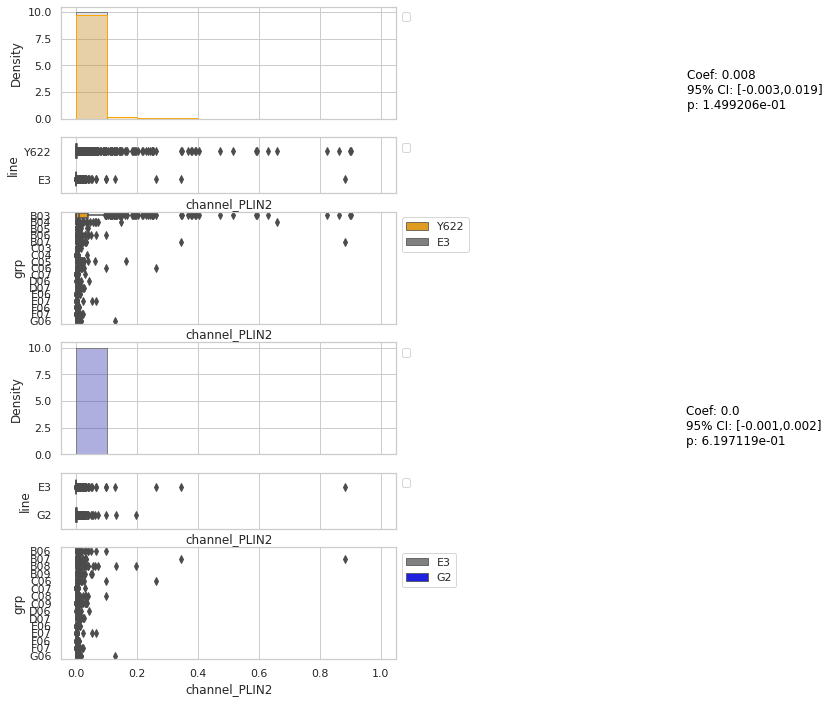

In [235]:
resF['grp'] = [x.split('_')[0] for x in resF['file']]
colors = dict(zip(np.unique(resV['line']), ['grey', 'blue', 'orange']))
plot_lines(resF, 'channel_PLIN2', 'vehicle', colors, False, .1, grp='grp')


<Axes: xlabel='channel_Lipidspot', ylabel='channel_PLIN2'>

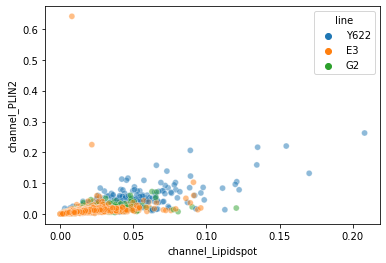

In [224]:
sns.scatterplot(data=resE[resE['treatment']=='vehicle'], x='channel_', y='channel_PLIN2', hue = 'line', alpha=.5)

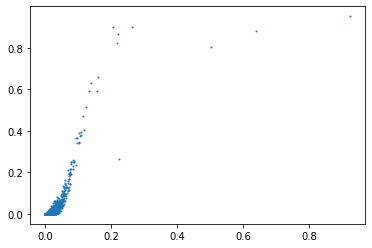

In [226]:
plt.scatter(resE['channel_PLIN2'], resF['channel_PLIN2'],1)
#plt.xlim(0,0.1)

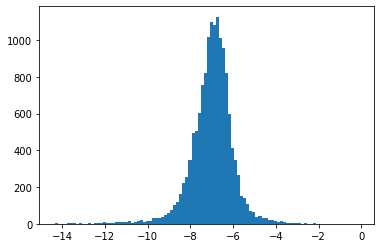

In [231]:
plt.hist(np.log2(resE['channel_PLIN2']+0.00001),100)
None

In [249]:
resV['grp'] = [x.split('_')[0] for x in resV['file']]


In [319]:
average_plin2 = resV.groupby(['grp', 'line', 'treatment'])['channel_Lipidspot', 'channel_PLIN2'].mean()
d = pd.DataFrame(average_plin2)
d = d.reset_index()
d.head()

/state/partition1/slurm_tmp/25531479.0.0/ipykernel_660921/4209355224.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  average_plin2 = resV.groupby(['grp', 'line', 'treatment'])['channel_Lipidspot', 'channel_PLIN2'].mean()


,grp,line,treatment,channel_Lipidspot,channel_PLIN2
0,B03,Y622,vehicle,0.001783,0.001036
1,B04,Y622,vehicle,0.001084,0.000264
2,B05,Y622,vehicle,0.000571,0.000172
3,B06,E3,vehicle,0.000818,0.000217
4,B07,E3,vehicle,0.000699,0.000826


vehicle_Y622 vs. vehicle_E3: t-test independent samples, P_val:9.320e-01 t=8.674e-02
vehicle_E3 vs. vehicle_G2: t-test independent samples, P_val:5.038e-01 t=6.876e-01


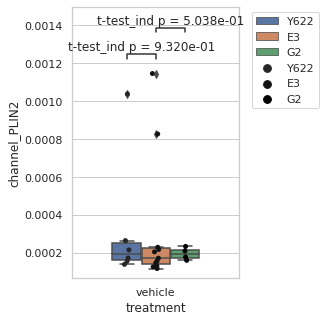

In [320]:
plt.figure(figsize=(3,5))
from statannotations.Annotator import Annotator

ax = sns.boxplot(data = d[d['treatment']=='vehicle'], x = 'treatment',hue='line', y = 'channel_PLIN2')#, hue = 'treat')
ax = sns.stripplot(data=d[d['treatment']=='vehicle'], x='treatment', hue='line', y='channel_PLIN2', dodge=True, color = 'black', edgecolor='black', alpha=1)

# Using statannotations
pairs = [(("vehicle", "Y622"), ("vehicle", "E3")), (("vehicle", "G2"), ("vehicle", "E3"))]  # Define pairs to compare
annotator = Annotator(ax, pairs, data=d[d['treatment']=='vehicle'], x='treatment', hue='line', y='channel_PLIN2')
annotator.configure(test='t-test_ind', text_format='full', loc='inside', verbose=2)
annotator.apply_and_annotate()
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
#plt.ylim(0,0.01)

Y622_vehicle vs. Y622_CDP-choline: t-test independent samples, P_val:2.471e-01 t=1.229e+00
Y622_vehicle vs. Y622_rosiglitazone: t-test independent samples, P_val:3.450e-01 t=9.912e-01


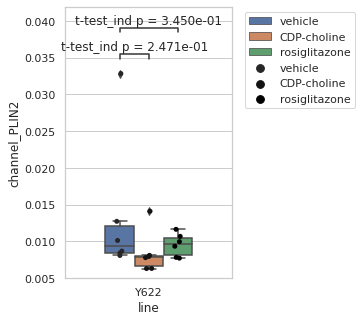

In [301]:

plt.figure(figsize=(3,5))
from statannotations.Annotator import Annotator
temp = d[d['line']=='Y622']
ax = sns.boxplot(data = temp, x = 'line',hue='treatment', y = 'channel_PLIN2')#, hue = 'treat')
ax = sns.stripplot(data= temp, x='line', hue='treatment', y='channel_PLIN2', dodge=True, color = 'black', edgecolor='black', alpha=1)

# Using statannotations
pairs = [(("Y622", "vehicle"), ("Y622", "CDP-choline")), (("Y622", "vehicle"), ( "Y622", "rosiglitazone"))]  # Define pairs to compare
annotator = Annotator(ax, pairs, data=temp, x='line', hue='treatment', y='channel_PLIN2')
annotator.configure(test='t-test_ind', text_format='full', loc='inside', verbose=2)
annotator.apply_and_annotate()
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")


G2_vehicle vs. G2_CDP-choline: t-test independent samples, P_val:6.275e-02 t=2.385e+00
G2_vehicle vs. G2_rosiglitazone: t-test independent samples, P_val:7.812e-01 t=-2.886e-01


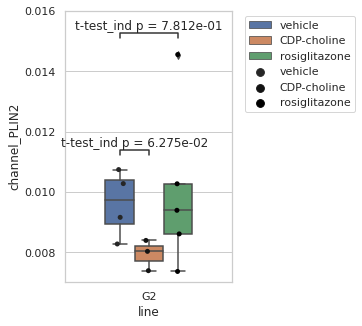

In [256]:

plt.figure(figsize=(3,5))
from statannotations.Annotator import Annotator
temp = d[d['line']=='G2']
ax = sns.boxplot(data = temp, x = 'line',hue='treatment', y = 'channel_PLIN2')#, hue = 'treat')
ax = sns.stripplot(data= temp, x='line', hue='treatment', y='channel_PLIN2', dodge=True, color = 'black', edgecolor='black', alpha=1)

# Using statannotations
pairs = [(("G2", "vehicle"), ("G2", "CDP-choline")), (("G2", "vehicle"), ( "G2", "rosiglitazone"))]  # Define pairs to compare
annotator = Annotator(ax, pairs, data=temp, x='line', hue='treatment', y='channel_PLIN2')
annotator.configure(test='t-test_ind', text_format='full', loc='inside', verbose=2)
annotator.apply_and_annotate()
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")


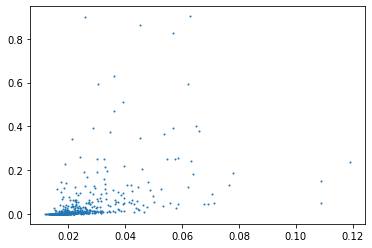

In [212]:
plt.scatter(resV['channel_PLIN2']/resE['channel_PLIN2'], resF['channel_PLIN2'],1)
#plt.xlim(0,0.05)
#plt.ylim(0,0.05)

In [214]:
np.argsort(np.array(resF[resF['ID']==0]['channel_PLIN2']))

array([  0,  59,  72, 193, 103, 104, 121, 143, 153, 156, 157, 163, 164,
       165, 166,  57, 168, 173, 176, 177, 178, 182, 183, 184, 186, 187,
       188, 189, 190, 191, 192, 172,  33, 194,  30,   1,   2,   3,   4,
         5,   6,   7,  14,   8,  10,  13,  11, 105, 114, 118, 181,  15,
       162, 179, 101, 123,  56, 145, 171, 159, 180,  18, 136,  26, 185,
       174,  63, 131,  32,  61,  28,  77,  84, 152,  97,  98,  31,  46,
        48,  54,  41,  50,  35,  16, 144, 154,  27,  65,  79,  70, 120,
        34,  86, 160,  67,  19,  83,  82,  49, 175, 130, 109, 127,  12,
        62, 155,  60,  55, 128,  95,  93,  92,  99, 111,  24,  74, 115,
        58,  88,  45, 124,  73,  53, 142,  42, 129, 116,  68,  75, 112,
       147,  64, 117,  29,  91,  40,  90,  44,  39, 106, 108, 100, 137,
        21,  76,  89,  20, 107,   9,  96,  66, 151, 133,  85, 125, 126,
        87,  38,  22, 138, 110, 170,  25,  80,  36,  51,  69, 149, 146,
       167, 141,  52,  47, 161,  81,  23, 139,  71,  94, 132,  1

(array([163.,  23.,   3.,   1.,   1.,   1.,   1.,   0.,   1.,   1.]),
 array([1.85477974e-05, 2.65248439e-03, 5.28642099e-03, 7.92035759e-03,
        1.05542942e-02, 1.31882308e-02, 1.58221674e-02, 1.84561040e-02,
        2.10900406e-02, 2.37239772e-02, 2.63579138e-02]),
 <BarContainer object of 10 artists>)

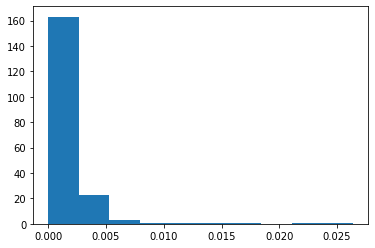

In [180]:
plt.hist(resV[resV['ID']==0]['channel_Lipidspot'])

In [165]:
resE[resE['ID']==0].loc[148]

channel_DAPI          0.145199
channel_NeuN           0.00887
channel_Lipidspot     0.208113
channel_PLIN2         0.262791
ID                           0
file                 B03_1.czi
line                      Y622
treatment              vehicle
well                 B03_1.czi
size                     472.0
Name: 148, dtype: object

In [166]:
x = out_float_sele[:,:,:,2][masks_sele==149]

In [167]:
y = probs_sele[masks_sele==149]

In [168]:
np.dot(x,y/np.sum(y))

0.20811316428361723

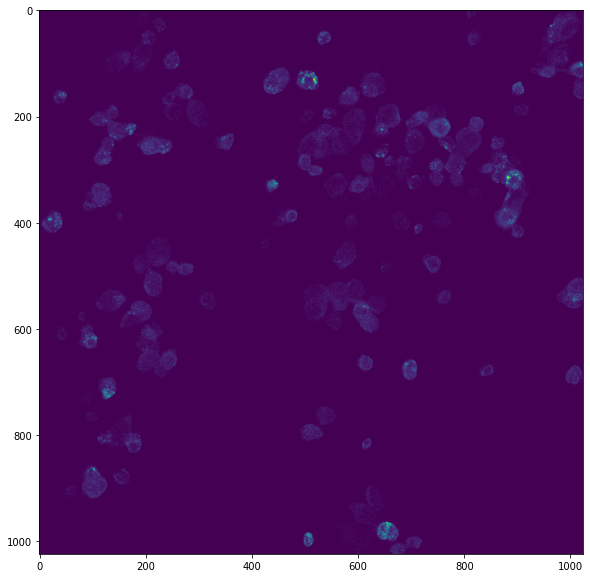

In [215]:
ID = 0
start = ID*zi_per_job
end = start + Nzi_per_job[ID][0]

probs_sele = probs[start:end]
masks_sele = all_masks[start:end]#.ravel()
out_float_sele = all_mat[start:end]

f = out_float_sele[:,:,:,2].copy()
f[masks_sele==0]=0

plt.figure(figsize=(10,10))
plt.imshow(np.max(f,axis=0))

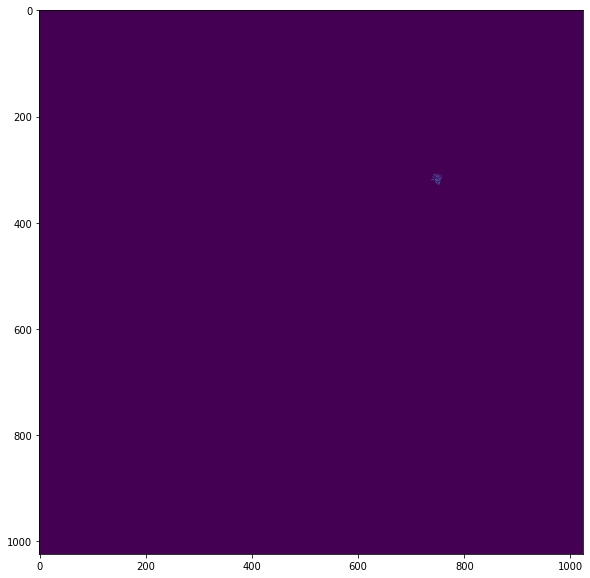

In [219]:
f = out_float_sele[:,:,:,2].copy()
f[masks_sele!=182+1]=0

plt.figure(figsize=(10,10))
plt.imshow(np.max(f, axis=0))

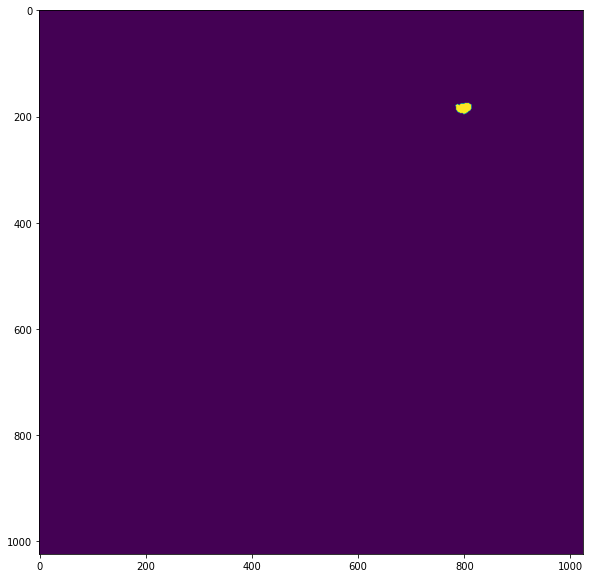

In [65]:
plt.figure(figsize=(10,10))
plt.imshow(np.max(masks_sele==193, axis=0))

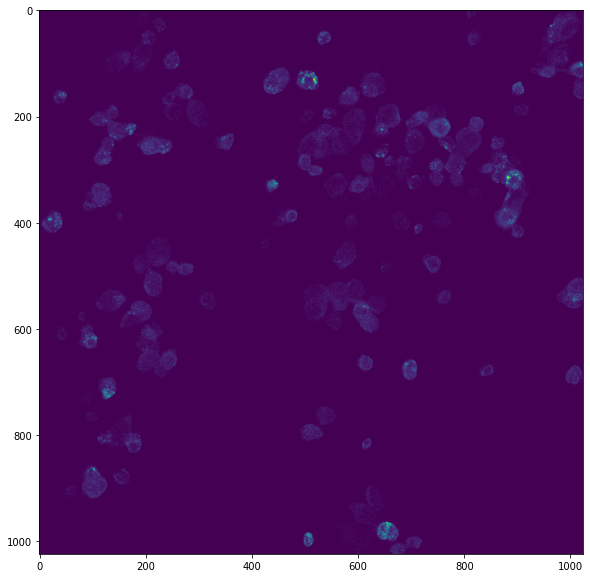

In [162]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import numba as nb
from statsmodels.regression.mixed_linear_model import MixedLM
from statsmodels.formula.api import mixedlm


def return_percentiles_all_images(files, zi_per_job, Nzi_per_job, all_masks, all_mat, out_float_sele):
    LS = []
    PL = []

    for ID in tqdm(range(len(files))):
            start = ID*zi_per_job
            end = start + Nzi_per_job[ID][0]

            masks_sele = all_masks[start:end]
            out_float_sele = all_mat[start:end]

            i = masks_sele>0
            LS.append(out_float_sele[:,:,:,1][i])
            PL.append(out_float_sele[:,:,:,2][i])
            
    l = np.hstack(LS)
    p = np.hstack(PL)

    return l, p

# get meta
def get_meta_vectors(in_parent, files):
    meta = pd.read_csv(in_parent + 'temp.csv')
    meta.columns = ['well', 'Treatment']
    meta['line'] = np.array([str(x).split(' ')[0] for x in meta['Treatment']])
    meta['treatment'] = np.array([str(x).split(' ')[1] if len(str(x).split(' '))>1 else np.nan for x in meta['Treatment']])
    meta['well'] = [x.split('-')[0] for x in meta['well']]

    dictionary = dict(zip(meta['well'], meta['line']))
    dictionary2 = dict(zip(meta['well'], meta['treatment']))

    lines = np.array([dictionary[x.split('_')[0]] for x in files])
    treat = np.array([dictionary2[x.split('_')[0]] for x in files])
    return lines, treat

@nb.njit(parallel=True)
def get_expectations(M_unique, masks_sele, probs_sele, vals_sele, E, V, N, F, thresh):
    """
    Calculate expectations, variance, and count for each unique mask value.

    Parameters:
    - M_unique (int): Number of unique mask values.
    - masks_sele (np.ndarray): Selected mask values.
    - probs_sele (np.ndarray): Probabilities associated with the mask values.
    - vals_sele (np.ndarray): Values associated with the mask values.
    - E (np.ndarray): Array to store expectations.
    - V (np.ndarray): Array to store variance.
    - N (np.ndarray): Array to store count.

    Returns:
    - None: Modifies the input arrays in-place.
    """
    for M in nb.prange(M_unique):
        index = masks_sele==M
        temp_probs = probs_sele[index]
        temp_vals = vals_sele[index]

        #E_uniform[M] = np.mean(temp_vals)
        P = temp_probs/np.sum(temp_probs)
        E[M] = np.dot(temp_vals, P)
        V[M] = np.dot((np.power((temp_vals-E[M]),2)), P)#/E[M]
        N[M] = np.sum(index)
        F[M] = np.sum(temp_vals>thresh)/N[M]
        
def compute_intensities(channels, channel_names, files, zi_per_job, Nzi_per_job, probs, all_masks, all_mat, lines, treat, thresh):

    resE = []
    resV = []
    resN = []
    resF = []

    for ID in tqdm(range(len(files))):
        start = ID*zi_per_job
        end = start + Nzi_per_job[ID][0]

        probs_sele = probs[start:end].ravel()
        masks_sele = all_masks[start:end].ravel()
        out_float_sele = all_mat[start:end]

        M_unique = np.unique(masks_sele)
        NM = len(M_unique)

        outputs_E = np.empty((NM, len(channels)))
        outputs_V = np.empty((NM, len(channels)))
        outputs_N = np.empty((NM, len(channels)))
        outputs_F = np.empty((NM, len(channels)))

        E = np.empty(NM)
        V = np.empty(NM)
        N = np.empty(NM)
        F = np.empty(NM)

        for C in channels:
            vals_sele = out_float_sele[:,:,:,C].ravel()
            get_expectations(NM, masks_sele, probs_sele, vals_sele, E, V, N, F, thresh[C])
            outputs_E[:,C] = E
            outputs_V[:,C] = V
            outputs_N[:,C] = N
            outputs_F[:,C] = F

        df_E = pd.DataFrame(outputs_E[1:])
        df_E.columns = ['channel_' + str(i) for i in channel_names]
        df_E['ID'] = ID
        df_E['file'] = files[ID]
        df_E['line'] = lines[ID]
        df_E['treatment'] = treat[ID]
        #df_E.index = M_unique[1:]
        
        df_F = pd.DataFrame(outputs_F[1:])
        df_F.columns = ['channel_' + str(i) for i in channel_names]
        df_F['ID'] = ID
        df_F['file'] = files[ID]
        df_F['line'] = lines[ID]
        df_F['treatment'] = treat[ID]
        #df_F.index = M_unique[1:]

        df_V = pd.DataFrame(outputs_V[1:])
        df_V.columns = ['channel_' + str(i) for i in channel_names]
        df_V['ID'] = ID
        df_V['file'] = files[ID]
        df_V['line'] = lines[ID]
        df_V['treatment'] = treat[ID]
        #df_V.index = M_unique[1:]

        df_N = pd.DataFrame(outputs_N[1:])

        resE.append(df_E)
        resV.append(df_V)
        resN.append(df_N)
        resF.append(df_F)

    # concatenate the results

    resE = pd.concat(resE)
    resE['well'] = [x.split('-')[0] for x in resE['file']]
    resE.index = range(resE.shape[0])

    resF = pd.concat(resF)
    resF['well'] = [x.split('-')[0] for x in resF['file']]
    resF.index = range(resE.shape[0])
    
    resV = pd.concat(resV)
    resV['well'] = [x.split('-')[0] for x in resV['file']]
    resV.index = range(resV.shape[0])

    resN = pd.concat(resN)
    resN.index = range(resN.shape[0])
    resE['size'] = resN[0]
                        
    return resV, resN, resE, resF

In [9]:
ID = 10

In [10]:
start = ID*zi_per_job
end = start + Nzi_per_job[ID][0]

masks_sele = all_masks[start:end]#.ravel()
out_float_sele = all_mat[start:end]

vals_sele = out_float_sele[:,:,:,2].ravel()

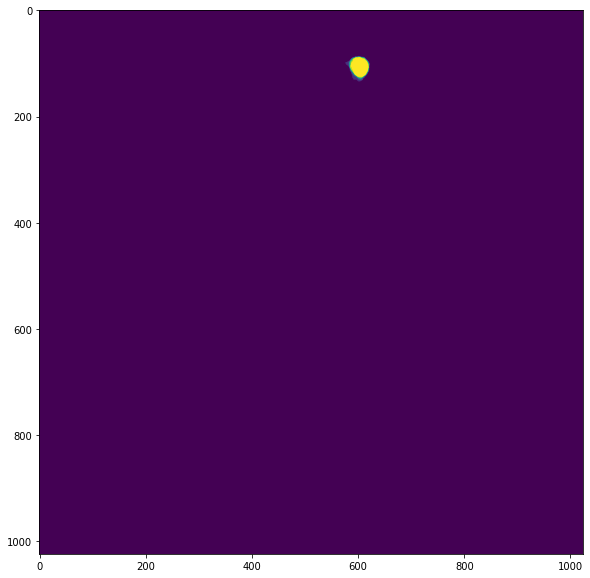

In [14]:
plt.figure(figsize=(10,10))

plt.imshow(np.sum(masks_sele==3, axis=0))

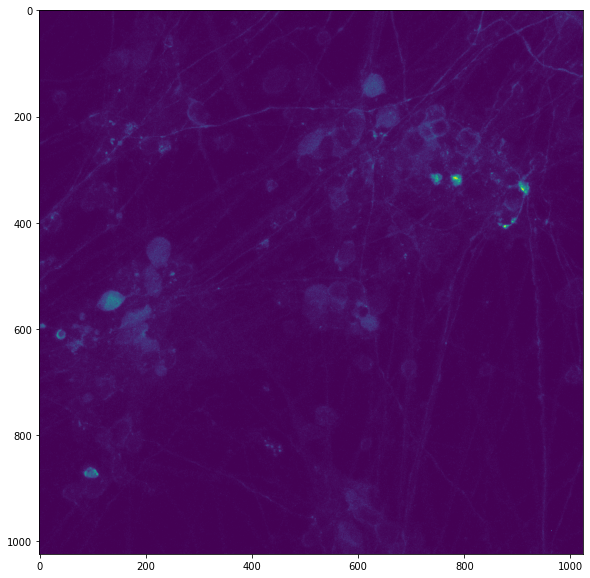

In [148]:
plt.figure(figsize=(10,10))
plt.imshow(np.max(out_float_sele[:,:,:,1], axis=0))

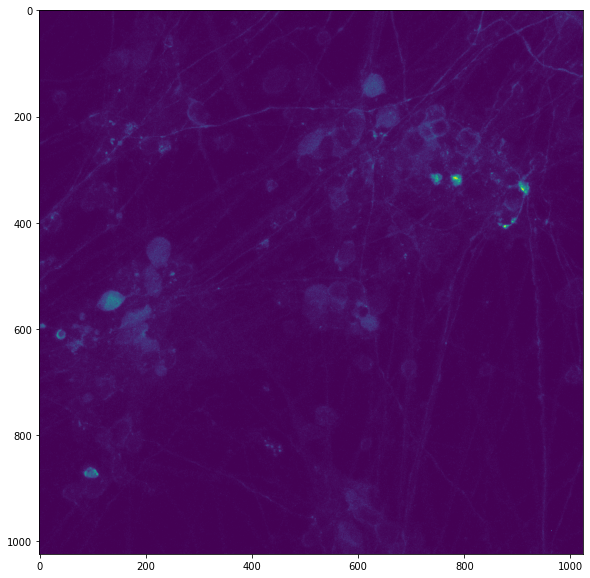

In [140]:
plt.figure(figsize=(10,10))
plt.imshow(np.max(out_float_sele[:,:,:,1], axis=0))

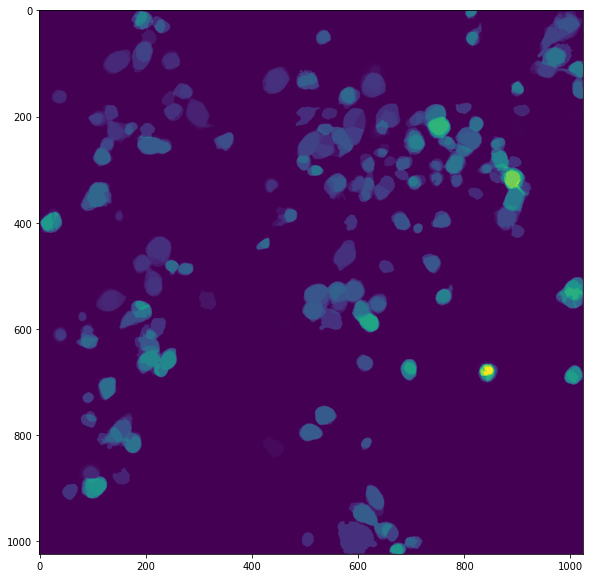

In [149]:
plt.figure(figsize=(10,10))

plt.imshow(np.sum(masks_sele, axis=0))

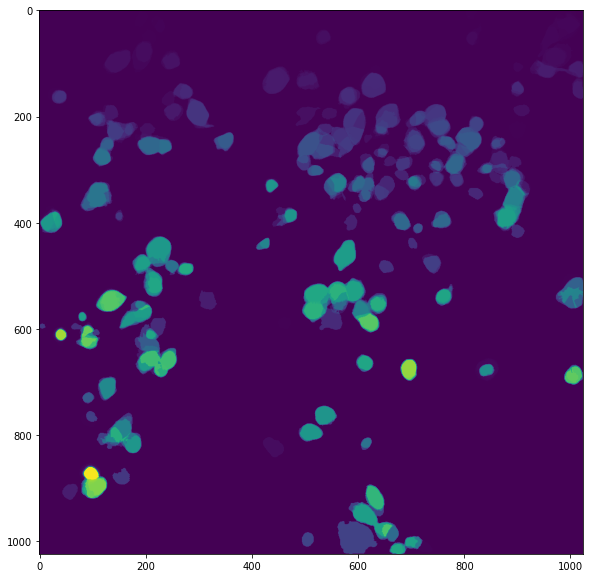

In [142]:
plt.figure(figsize=(10,10))

plt.imshow(np.sum(masks_sele, axis=0))

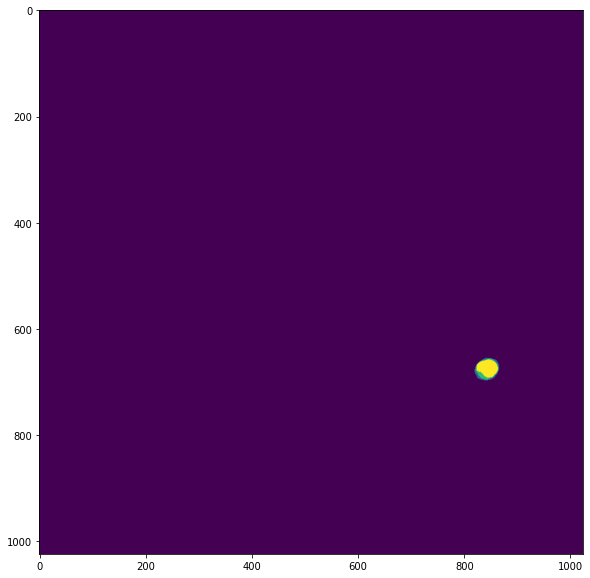

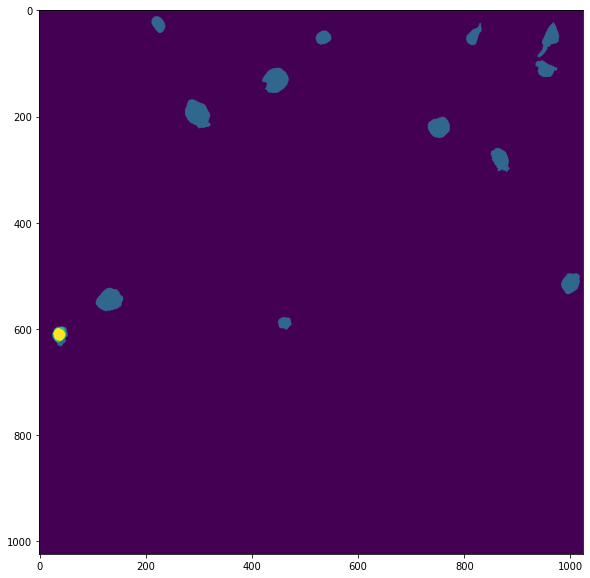

In [143]:
plt.figure(figsize=(10,10))

plt.imshow(np.sum(masks_sele==4, axis=0))

In [6]:
from cellpose.utils import stitch3D

In [94]:
M = masks_sele.copy()
M = stitch3D(M)#.ravel()

In [96]:
PLIN_thresh=0.11372549019607843
M2 = M.ravel()

In [97]:
PLIN_thresh=0.11372549019607843
M2 = M.ravel()

M = masks_sele.copy()
M = stitch3D(M)

o = []
for i in np.unique(M2):
    index = M2==i
    temp_vals = vals_sele[index]
    o.append(np.sum(temp_vals>PLIN_thresh)/len(temp_vals))

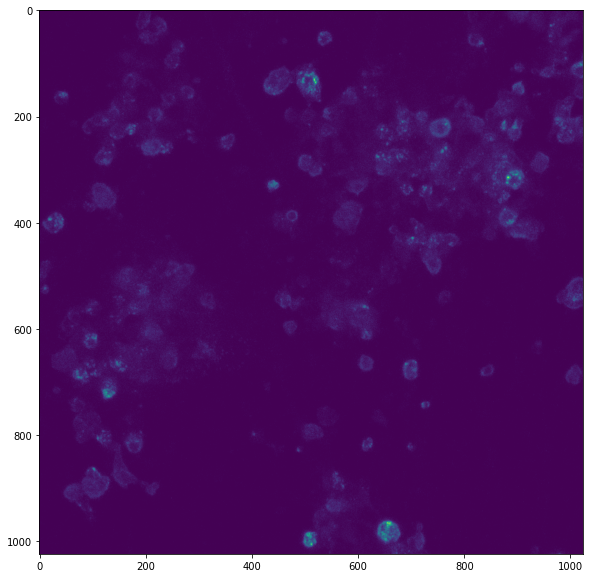

In [111]:
plt.figure(figsize=(10,10))
plt.imshow(np.mean(out_float_sele[:,:,:,2], axis=0))

In [126]:
F = out_float_sele[:,:,:,2].copy()

In [115]:
F.shape

(23, 1024, 1024)

In [127]:
F[M!=1]=0

(500.0, 600.0)

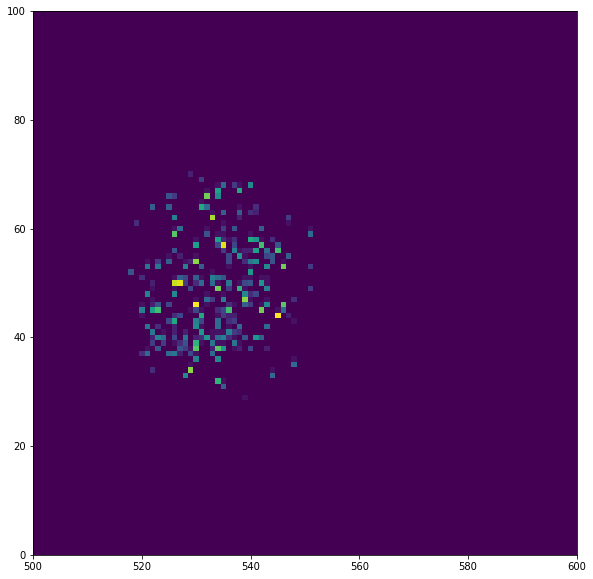

In [130]:
plt.figure(figsize=(10,10))
plt.imshow(np.mean(F, axis=0))
plt.ylim(0,100)
plt.xlim(500,600)

In [108]:
F = np.mean(out_float_sele[:,:,:,2], axis=0)
F[np.mean(M!=17, axis=0).astype(bool)]=0

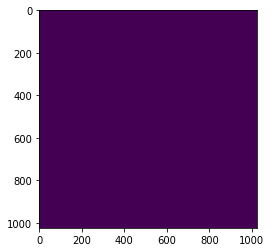

In [109]:
plt.imshow(F)

In [103]:
np.mean(M==17, axis=0)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

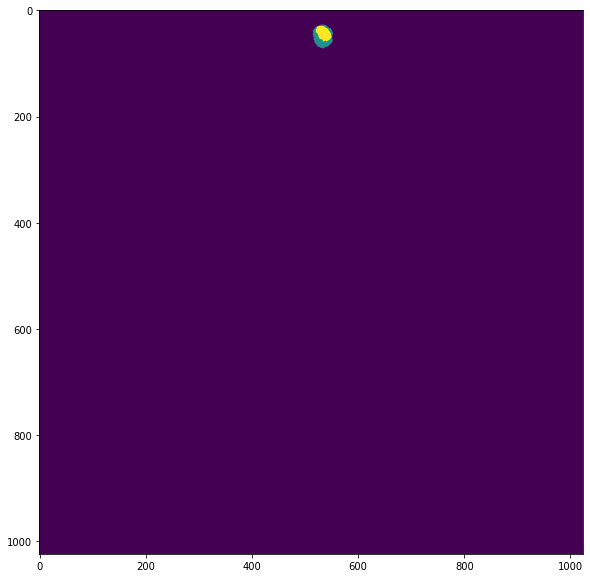

In [125]:
plt.figure(figsize=(10,10))

plt.imshow(np.mean(M==1, axis=0))

In [124]:
np.argwhere(np.array(o)<0.01)

array([[  0],
       [  1],
       [  2],
       [  3],
       [  4],
       [  5],
       [  6],
       [  7],
       [  8],
       [  9],
       [ 11],
       [ 12],
       [ 13],
       [ 14],
       [ 15],
       [ 16],
       [ 19],
       [ 20],
       [ 27],
       [ 28],
       [ 29],
       [ 31],
       [ 33],
       [ 34],
       [ 35],
       [ 42],
       [ 46],
       [ 47],
       [ 49],
       [ 50],
       [ 51],
       [ 56],
       [ 58],
       [ 59],
       [ 61],
       [ 63],
       [ 64],
       [ 65],
       [ 67],
       [ 69],
       [ 74],
       [ 75],
       [ 76],
       [ 81],
       [ 86],
       [ 90],
       [103],
       [105],
       [106],
       [107],
       [112],
       [117],
       [121],
       [124],
       [125],
       [133],
       [134],
       [135],
       [136],
       [141],
       [147],
       [148],
       [149],
       [156],
       [160],
       [163],
       [164],
       [165],
       [169],
       [170],
       [173],
      

In [85]:
np.percentile(np.array(o),90)

0.11998494844651923

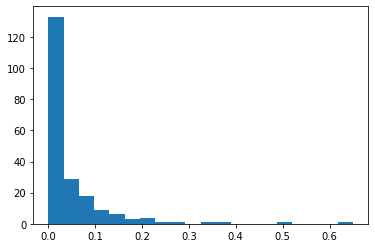

In [88]:
plt.hist((np.array(o)+0.001), 20)
None

In [ ]:

        #E_uniform[M] = np.mean(temp_vals)
        P = temp_probs/np.sum(temp_probs)
        E[M] = np.dot(temp_vals, P)
        V[M] = np.dot((np.power((temp_vals-E[M]),2)), P)/E[M]
        N[M] = np.sum(index)

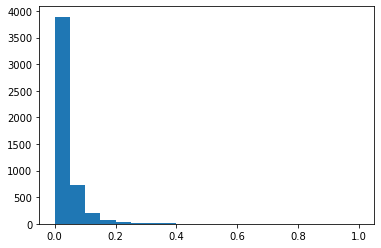

In [36]:

plt.hist((l[np.random.randint(0,len(p),5000)]), 20)
None

In [39]:
np.sum(l>0)/len(l)

0.7432289339810092

(23, 1024, 1024)

In [92]:
lines, treat = get_meta_vectors(in_parent, files)
channels = [0,1,2,3]
channel_names = ['DAPI', 'NeuN', 'Lipidspot', 'PLIN2']
resV, resN, resE = compute_intensities(channels, channel_names, files, zi_per_job, Nzi_per_job, probs, all_masks, all_mat, lines, treat)

100%|██████████| 96/96 [08:23<00:00,  5.24s/it]


In [219]:
resE.to_csv(out_parent+'quant.csv')
resV.to_csv(out_parent+'resV.csv')

In [220]:
resV

,channel_DAPI,channel_NeuN,channel_Lipidspot,channel_PLIN2,ID,file,line,treatment,well
0,0.175379,0.025916,0.045785,0.037471,0,B03_1.czi,Y622,vehicle,B03_1.czi
1,0.207400,0.030673,0.050858,0.031002,0,B03_1.czi,Y622,vehicle,B03_1.czi
2,0.137740,0.035200,0.047372,0.039306,0,B03_1.czi,Y622,vehicle,B03_1.czi
3,0.289617,0.034520,0.072112,0.064052,0,B03_1.czi,Y622,vehicle,B03_1.czi
4,0.214715,0.036201,0.066589,0.063962,0,B03_1.czi,Y622,vehicle,B03_1.czi
...,...,...,...,...,...,...,...,...,...
6779,0.040455,0.021336,0.036939,0.017464,95,G09_3.czi,G2,rosiglitazone,G09_3.czi
6780,0.048260,0.033516,0.204758,0.015674,95,G09_3.czi,G2,rosiglitazone,G09_3.czi
6781,0.032901,0.027801,0.038096,0.015133,95,G09_3.czi,G2,rosiglitazone,G09_3.czi
6782,0.043093,0.025418,0.034907,0.018470,95,G09_3.czi,G2,rosiglitazone,G09_3.czi


(0.0, 0.1)

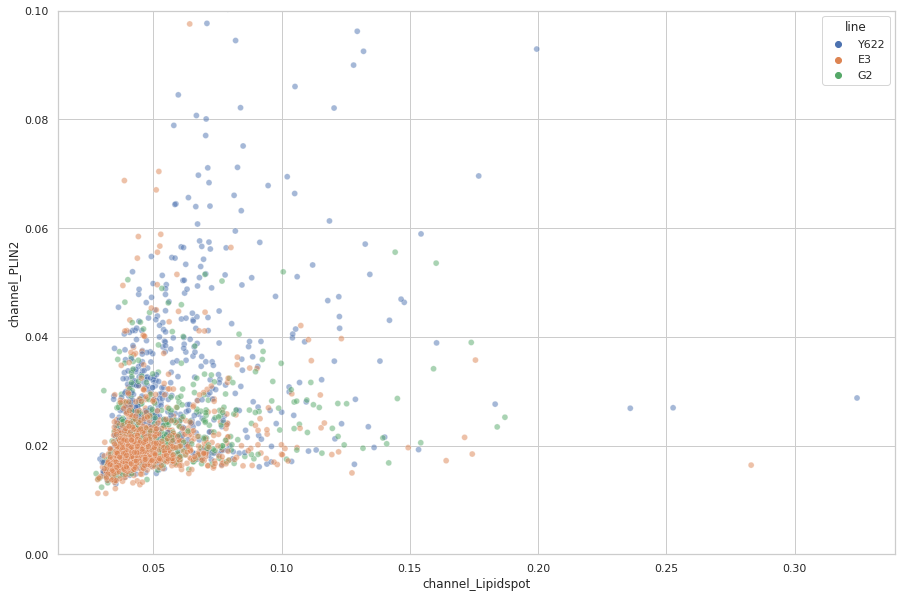

In [239]:
sns.scatterplot(data=resV[resV['treatment']=='vehicle'], x='channel_Lipidspot', y='channel_PLIN2', hue = 'line', alpha=.5)
plt.ylim(0,0.1)

<Axes: xlabel='channel_Lipidspot', ylabel='channel_PLIN2'>

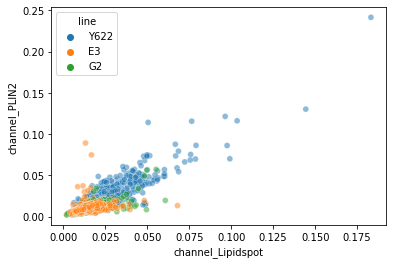

In [113]:
sns.scatterplot(data=resE[resE['treatment']=='vehicle'], x='channel_Lipidspot', y='channel_PLIN2', hue = 'line', alpha=.5)

In [181]:
resE

,channel_DAPI,channel_NeuN,channel_Lipidspot,channel_PLIN2,ID,file,line,treatment,well,size,grp,treatment2
0,0.073882,0.007550,0.007474,0.009945,0,B03_1.czi,Y622,vehicle,B03_1.czi,20038.0,B03,Y622 + vehicle
1,0.088154,0.011478,0.011948,0.012823,0,B03_1.czi,Y622,vehicle,B03_1.czi,16148.0,B03,Y622 + vehicle
2,0.092628,0.014258,0.014191,0.017924,0,B03_1.czi,Y622,vehicle,B03_1.czi,19684.0,B03,Y622 + vehicle
3,0.155061,0.016795,0.017816,0.027390,0,B03_1.czi,Y622,vehicle,B03_1.czi,14273.0,B03,Y622 + vehicle
4,0.110614,0.017744,0.015508,0.022386,0,B03_1.czi,Y622,vehicle,B03_1.czi,15234.0,B03,Y622 + vehicle
...,...,...,...,...,...,...,...,...,...,...,...,...
6779,0.096851,0.008923,0.006605,0.005074,95,G09_3.czi,G2,rosiglitazone,G09_3.czi,2502.0,G09,G2 + rosiglitazone
6780,0.118173,0.023419,0.028945,0.009068,95,G09_3.czi,G2,rosiglitazone,G09_3.czi,1475.0,G09,G2 + rosiglitazone
6781,0.124365,0.007123,0.006492,0.006084,95,G09_3.czi,G2,rosiglitazone,G09_3.czi,949.0,G09,G2 + rosiglitazone
6782,0.086092,0.011152,0.006209,0.005737,95,G09_3.czi,G2,rosiglitazone,G09_3.czi,1836.0,G09,G2 + rosiglitazone


In [202]:
resE.head()

,channel_DAPI,channel_NeuN,channel_Lipidspot,channel_PLIN2,ID,file,line,treatment,well,size,grp,treatment2
0,0.073882,0.007550,0.007474,0.009945,0,B03_1.czi,Y622,vehicle,B03_1.czi,20038.0,B03,Y622 + vehicle
1,0.088154,0.011478,0.011948,0.012823,0,B03_1.czi,Y622,vehicle,B03_1.czi,16148.0,B03,Y622 + vehicle
2,0.092628,0.014258,0.014191,0.017924,0,B03_1.czi,Y622,vehicle,B03_1.czi,19684.0,B03,Y622 + vehicle
3,0.155061,0.016795,0.017816,0.027390,0,B03_1.czi,Y622,vehicle,B03_1.czi,14273.0,B03,Y622 + vehicle
4,0.110614,0.017744,0.015508,0.022386,0,B03_1.czi,Y622,vehicle,B03_1.czi,15234.0,B03,Y622 + vehicle


In [232]:
average_plin2 = resV.groupby(['grp', 'line', 'treatment'])['channel_Lipidspot', 'channel_PLIN2'].mean()
d = pd.DataFrame(average_plin2)
d = d.reset_index()
d.head()

/state/partition1/slurm_tmp/25527582.0.0/ipykernel_3030176/4209355224.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  average_plin2 = resV.groupby(['grp', 'line', 'treatment'])['channel_Lipidspot', 'channel_PLIN2'].mean()


,grp,line,treatment,channel_Lipidspot,channel_PLIN2
0,B03,Y622,vehicle,0.064482,0.042461
1,B04,Y622,vehicle,0.055070,0.024713
2,B05,Y622,vehicle,0.048693,0.022303
3,B06,E3,vehicle,0.050996,0.020777
4,B07,E3,vehicle,0.050246,0.065213


Y622_vehicle vs. Y622_CDP-choline: t-test independent samples, P_val:1.469e-01 t=1.572e+00
Y622_vehicle vs. Y622_rosiglitazone: t-test independent samples, P_val:1.535e-01 t=1.545e+00


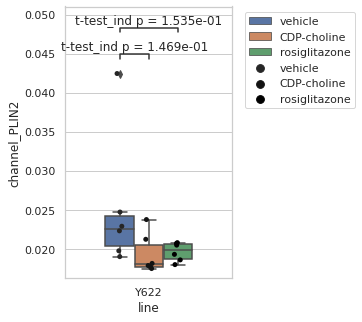

In [233]:
average_plin2 = resV.groupby(['grp', 'line', 'treatment'])['channel_Lipidspot', 'channel_PLIN2'].mean()
d = pd.DataFrame(average_plin2)
d = d.reset_index()
d.head()

plt.figure(figsize=(3,5))
from statannotations.Annotator import Annotator
temp = d[d['line']=='Y622']
ax = sns.boxplot(data = temp, x = 'line',hue='treatment', y = 'channel_PLIN2')#, hue = 'treat')
ax = sns.stripplot(data= temp, x='line', hue='treatment', y='channel_PLIN2', dodge=True, color = 'black', edgecolor='black', alpha=1)

# Using statannotations
pairs = [(("Y622", "vehicle"), ("Y622", "CDP-choline")), (("Y622", "vehicle"), ( "Y622", "rosiglitazone"))]  # Define pairs to compare
annotator = Annotator(ax, pairs, data=temp, x='line', hue='treatment', y='channel_PLIN2')
annotator.configure(test='t-test_ind', text_format='full', loc='inside', verbose=2)
annotator.apply_and_annotate()
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")


Y622_vehicle vs. Y622_CDP-choline: t-test independent samples, P_val:5.350e-02 t=2.188e+00
Y622_vehicle vs. Y622_rosiglitazone: t-test independent samples, P_val:1.278e-01 t=1.661e+00


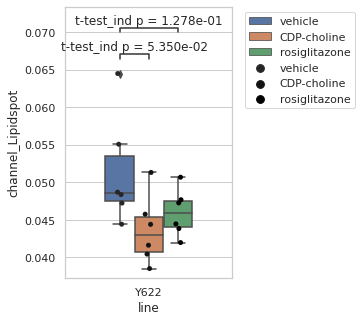

In [234]:
plt.figure(figsize=(3,5))
from statannotations.Annotator import Annotator
temp = d[d['line']=='Y622']
ax = sns.boxplot(data = temp, x = 'line',hue='treatment', y = 'channel_Lipidspot')#, hue = 'treat')
ax = sns.stripplot(data= temp, x='line', hue='treatment', y='channel_Lipidspot', dodge=True, color = 'black', edgecolor='black', alpha=1)

# Using statannotations
pairs = [(("Y622", "vehicle"), ("Y622", "CDP-choline")), (("Y622", "vehicle"), ( "Y622", "rosiglitazone"))]  # Define pairs to compare
annotator = Annotator(ax, pairs, data=temp, x='line', hue='treatment', y='channel_Lipidspot')
annotator.configure(test='t-test_ind', text_format='full', loc='inside', verbose=2)
annotator.apply_and_annotate()
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")


G2_vehicle vs. G2_CDP-choline: t-test independent samples, P_val:4.220e-02 t=2.711e+00
G2_vehicle vs. G2_rosiglitazone: t-test independent samples, P_val:4.351e-01 t=-8.278e-01


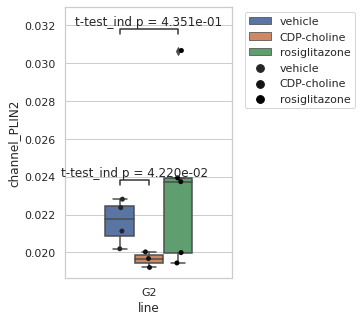

In [235]:
plt.figure(figsize=(3,5))
from statannotations.Annotator import Annotator
temp = d[d['line']=='G2']
ax = sns.boxplot(data = temp, x = 'line',hue='treatment', y = 'channel_PLIN2')#, hue = 'treat')
ax = sns.stripplot(data= temp, x='line', hue='treatment', y='channel_PLIN2', dodge=True, color = 'black', edgecolor='black', alpha=1)

# Using statannotations
pairs = [(("G2", "vehicle"), ("G2", "CDP-choline")), (("G2", "vehicle"), ( "G2", "rosiglitazone"))]  # Define pairs to compare
annotator = Annotator(ax, pairs, data=temp, x='line', hue='treatment', y='channel_PLIN2')
annotator.configure(test='t-test_ind', text_format='full', loc='inside', verbose=2)
annotator.apply_and_annotate()
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")


vehicle_Y622 vs. vehicle_E3: t-test independent samples, P_val:9.838e-01 t=2.060e-02
vehicle_E3 vs. vehicle_G2: t-test independent samples, P_val:6.435e-01 t=4.738e-01


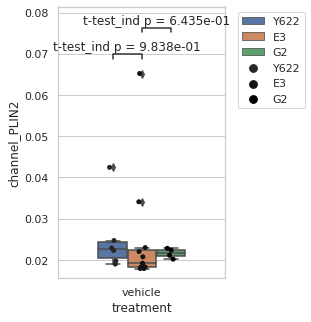

In [236]:
plt.figure(figsize=(3,5))
from statannotations.Annotator import Annotator

ax = sns.boxplot(data = d[d['treatment']=='vehicle'], x = 'treatment',hue='line', y = 'channel_PLIN2')#, hue = 'treat')
ax = sns.stripplot(data=d[d['treatment']=='vehicle'], x='treatment', hue='line', y='channel_PLIN2', dodge=True, color = 'black', edgecolor='black', alpha=1)

# Using statannotations
pairs = [(("vehicle", "Y622"), ("vehicle", "E3")), (("vehicle", "G2"), ("vehicle", "E3"))]  # Define pairs to compare
annotator = Annotator(ax, pairs, data=d[d['treatment']=='vehicle'], x='treatment', hue='line', y='channel_PLIN2')
annotator.configure(test='t-test_ind', text_format='full', loc='inside', verbose=2)
annotator.apply_and_annotate()
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")


vehicle_Y622 vs. vehicle_E3: t-test independent samples, P_val:7.748e-02 t=1.895e+00
vehicle_E3 vs. vehicle_G2: t-test independent samples, P_val:4.550e-03 t=-3.422e+00


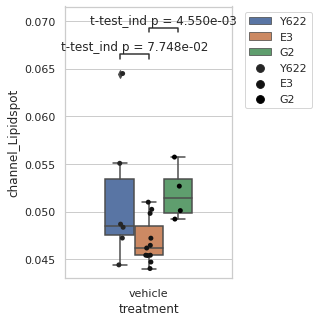

In [237]:
plt.figure(figsize=(3,5))
from statannotations.Annotator import Annotator

ax = sns.boxplot(data = d[d['treatment']=='vehicle'], x = 'treatment',hue='line', y = 'channel_Lipidspot')#, hue = 'treat')
ax = sns.stripplot(data=d[d['treatment']=='vehicle'], x='treatment', hue='line', y='channel_Lipidspot', dodge=True, color = 'black', edgecolor='black', alpha=1)

# Using statannotations
pairs = [(("vehicle", "Y622"), ("vehicle", "E3")), (("vehicle", "G2"), ("vehicle", "E3"))]  # Define pairs to compare
annotator = Annotator(ax, pairs, data=d[d['treatment']=='vehicle'], x='treatment', hue='line', y='channel_Lipidspot')
annotator.configure(test='t-test_ind', text_format='full', loc='inside', verbose=2)
annotator.apply_and_annotate()
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")


In [ ]:
plt.figure(figsize=(3,5))
ax = sns.boxplot(data = grouped_df[grouped_df['treat']=='vehicle'], x = 'treat',hue='line', y = 'fraction')#, hue = 'treat')
ax = sns.stripplot(data=grouped_df[grouped_df['treat']=='vehicle'], x='treat', hue='line', y='fraction', dodge=True, color = 'black', edgecolor='black', alpha=1)
plt.ylabel('fraction cells with PLIN2 particle count > 0')

# Using statannotations
pairs = [(("vehicle", "Y622"), ("vehicle", "E3")), (("vehicle", "G2"), ("vehicle", "E3"))]  # Define pairs to compare
annotator = Annotator(ax, pairs, data=grouped_df[grouped_df['treat']=='vehicle'], x='treat', hue='line', y='fraction')
annotator.configure(test='t-test_ind', text_format='full', loc='inside', verbose=2)
annotator.apply_and_annotate()
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")


<Axes: xlabel='channel_PLIN2', ylabel='treatment2'>

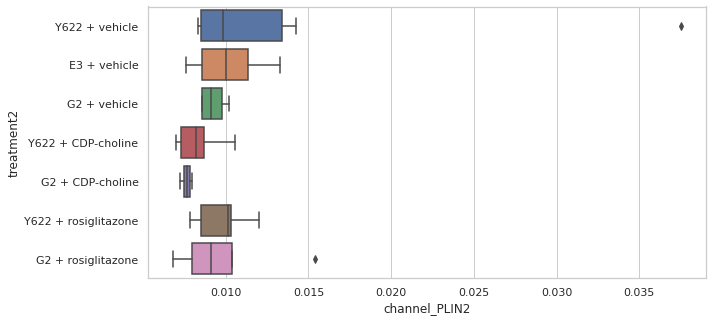

In [200]:
plt.figure(figsize=(10,5))
sns.boxplot(data = d, x = 'channel_PLIN2', y = 'treatment2')

<Axes: xlabel='line', ylabel='channel_PLIN2'>

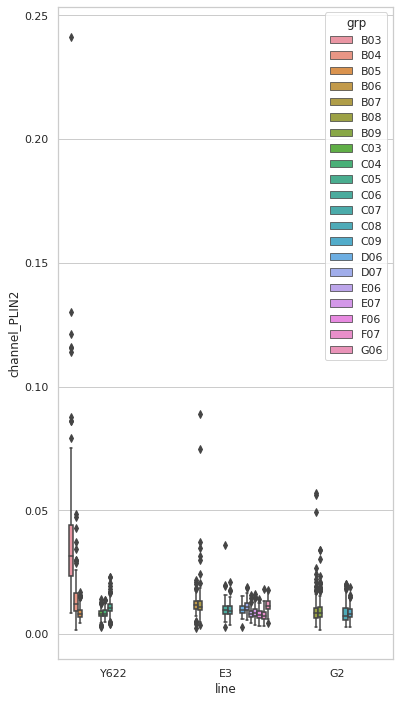

In [153]:
sns.boxplot(data=resE[resE['treatment']=='vehicle'], x='line', y='channel_PLIN2', hue = 'grp')

In [221]:
resV['grp'] = [x.split('_')[0] for x in resV['file']]
colors = dict(zip(np.unique(resV['line']), ['grey', 'blue', 'orange']))
plot_lines(resV, 'channel_Lipidspot', 'vehicle', colors, True, .1, grp='grp')


//home/gridsan/djuna/homer/github/confocalQuant/confocalQuant/plotting.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp[x] = np.log(df_temp[x])
/home/gridsan/djuna/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/gridsan/djuna/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.

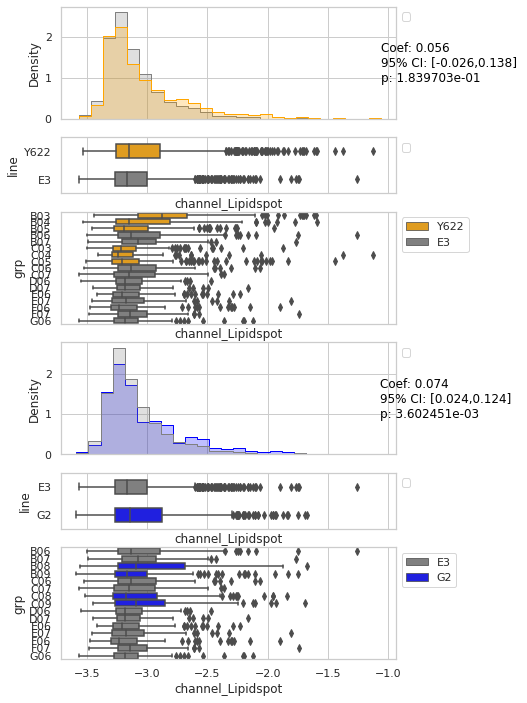

In [226]:
colors = dict(zip(np.unique(resV['line']), ['grey', 'blue', 'orange']))
plot_lines(resV, 'channel_Lipidspot', 'vehicle', colors, True, .1, grp='grp')


In [227]:
   
def plot_treatments(df_temp, x, colors, lognormal, binwidth,lab_height, line, grp='well', size=(20,7)):
    sns.set(rc={'figure.figsize':size})
    sns.set_style("whitegrid")
    #df_temp = df[df['line']==line]
    


    if lognormal:
        df_temp[x] = np.log(df_temp[x])
    
    f, ax = plt.subplots(3,len(np.unique(df_temp['treatment']))-1, sharex=True, gridspec_kw={"height_ratios": (1,.3,.5)})

    for i,t in enumerate(['CDP-choline',  'rosiglitazone']):
        index = (df_temp['treatment']=='vehicle') | (df_temp['treatment']==t)
        index2 = ((df_temp['treatment']=='vehicle') | (df_temp['treatment']==t)) &  (df_temp['line']==line)
        # compute pvalue 
        
        text = compute_nested_anova(df_temp[index2], x, 'treatment', grp)
        sns.histplot(data=df_temp[index].sort_values(by='treatment', ascending=True), x=x, ax=ax[0,i], hue='treatment2', binwidth=binwidth, element="step", common_norm=False, stat='density', palette = colors)
        
        ax[0,i].text(x=np.mean(df_temp[index][x]), y=lab_height, s=text, fontsize=12, color='black')
        
        #ax[0,i].legend(loc='lower left', bbox_to_anchor=(0, 1))
        sns.boxplot(data=df_temp[index], x=x, y='treatment2',orient="h", ax=ax[1,i], width=.8, dodge=True, palette = colors)#, order =(order))#, palette = colors)
        sns.boxplot(data=df_temp[index], x=x, y=grp,orient="h", ax=ax[2,i], width=1, dodge=False, hue = 'treatment2', palette = colors)#, order =(order))#, palette = colors)
        #ax[0,i].get_legend().remove()
        ax[2,i].get_legend().remove()
        ax[1,i].axes.get_yaxis().set_visible(False)



/state/partition1/slurm_tmp/25527582.0.0/ipykernel_3030176/379447611.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp[x] = np.log(df_temp[x])


<Figure size 720x720 with 0 Axes>

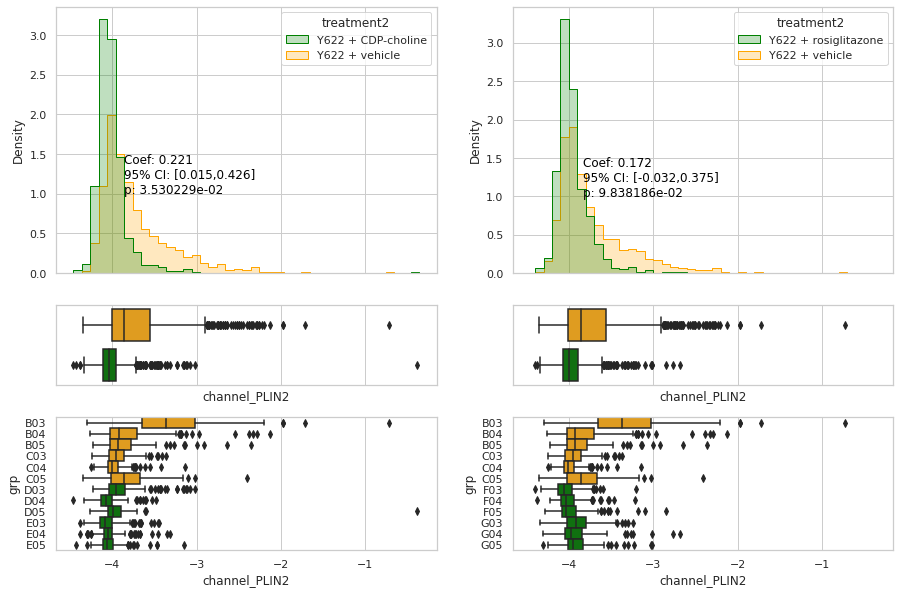

In [231]:
plt.figure(figsize=(10,10))
resV['treatment2'] = resV['line'] + ' + ' + resV['treatment']
d = resV[(resV['line']=='Y622')]

colors = dict(zip(np.unique(d['treatment2']), ['green', 'green', 'orange']))
plot_treatments(d, 'channel_PLIN2', colors, True, 0.1, 1, line='Y622', grp='grp', size=(15,10))


/state/partition1/slurm_tmp/25527582.0.0/ipykernel_3030176/379447611.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp[x] = np.log(df_temp[x])
/home/gridsan/djuna/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/gridsan/djuna/.local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/gridsan/djuna/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM o

<Figure size 720x720 with 0 Axes>

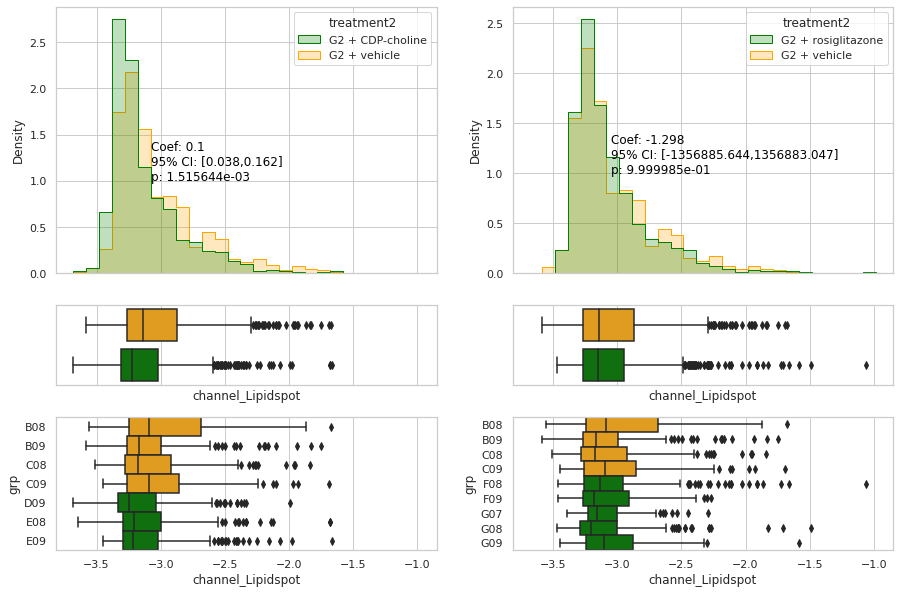

In [229]:
plt.figure(figsize=(10,10))
resV['treatment2'] = resV['line'] + ' + ' + resV['treatment']
d = resV[(resV['line']=='G2')]

colors = dict(zip(np.unique(d['treatment2']), ['green', 'green', 'orange']))
plot_treatments(d, 'channel_Lipidspot', colors, True, 0.1, 1, line='G2', grp='grp', size=(15,10))


/state/partition1/slurm_tmp/25527582.0.0/ipykernel_3030176/379447611.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp[x] = np.log(df_temp[x])
/home/gridsan/djuna/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<Figure size 720x720 with 0 Axes>

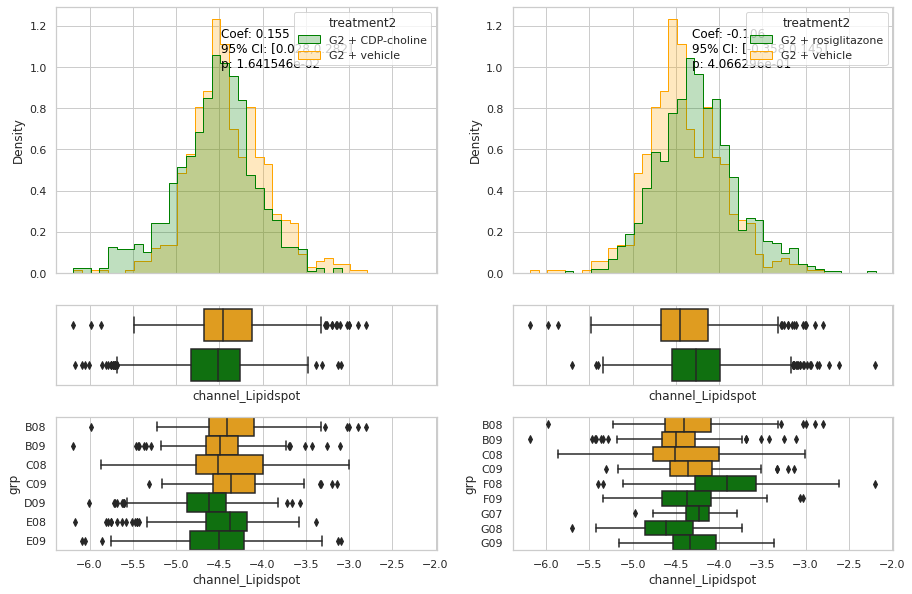

In [175]:
plt.figure(figsize=(10,10))
resE['treatment2'] = resE['line'] + ' + ' + resE['treatment']
d = resE[(resE['line']=='G2')]

colors = dict(zip(np.unique(d['treatment2']), ['green', 'green', 'orange']))
plot_treatments(d, 'channel_Lipidspot', colors, True, 0.1, 1, line='G2', grp='grp', size=(15,10))


/state/partition1/slurm_tmp/25527582.0.0/ipykernel_3030176/379447611.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp[x] = np.log(df_temp[x])


<Figure size 720x720 with 0 Axes>

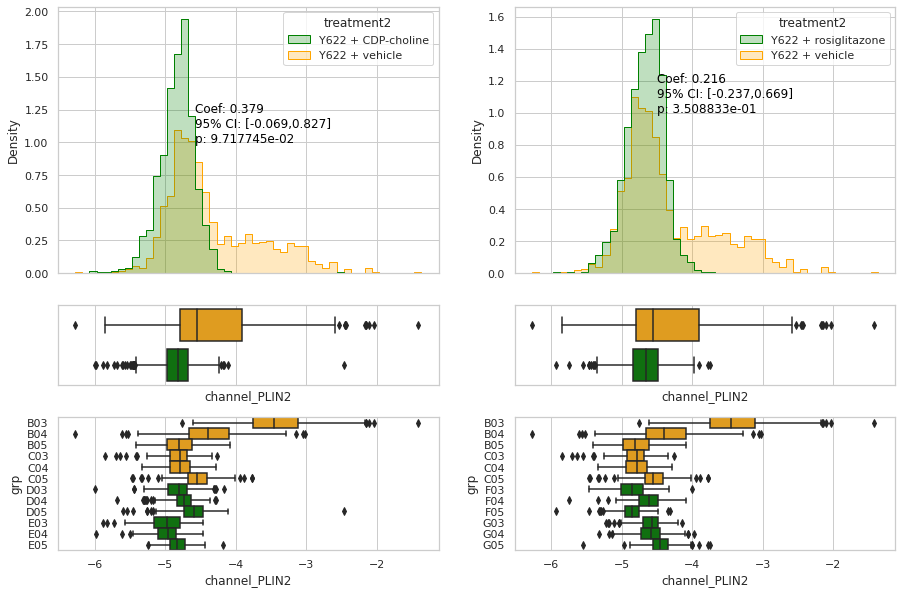

In [176]:
plt.figure(figsize=(10,10))
resE['treatment2'] = resE['line'] + ' + ' + resE['treatment']
d = resE[(resE['line']=='Y622')]

colors = dict(zip(np.unique(d['treatment2']), ['green', 'green', 'orange']))
plot_treatments(d, 'channel_PLIN2', colors, True, 0.1, 1, line='Y622', grp='grp', size=(15,10))


/state/partition1/slurm_tmp/25527582.0.0/ipykernel_3030176/379447611.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp[x] = np.log(df_temp[x])


<Figure size 720x720 with 0 Axes>

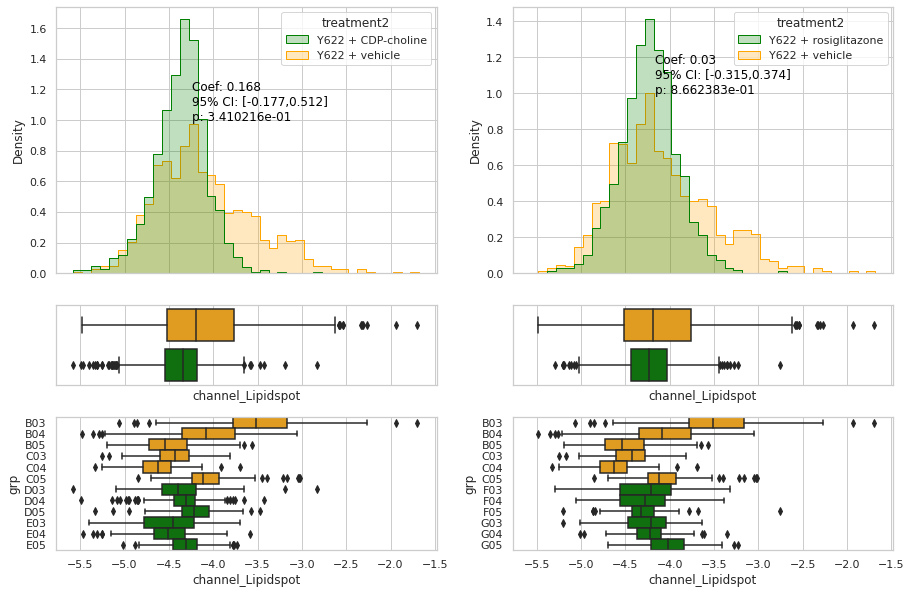

In [177]:
plt.figure(figsize=(10,10))
resE['treatment2'] = resE['line'] + ' + ' + resE['treatment']
d = resE[(resE['line']=='Y622')]

colors = dict(zip(np.unique(d['treatment2']), ['green', 'green', 'orange']))
plot_treatments(d, 'channel_Lipidspot', colors, True, 0.1, 1, line='Y622', grp='grp', size=(15,10))


/state/partition1/slurm_tmp/25527582.0.0/ipykernel_3030176/379447611.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp[x] = np.log(df_temp[x])


<Figure size 720x720 with 0 Axes>

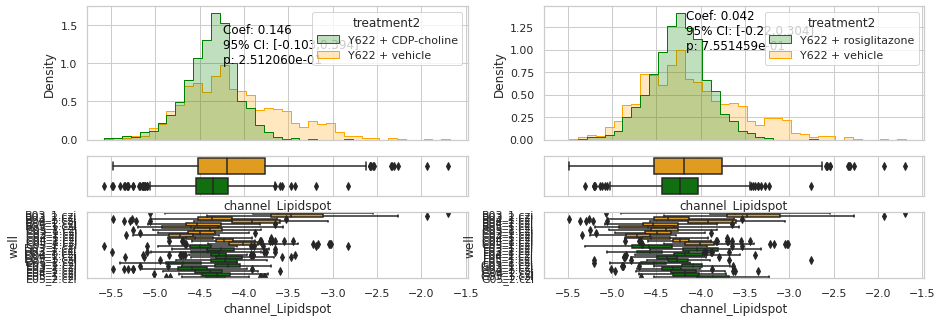

In [164]:
plt.figure(figsize=(10,10))
resE['treatment2'] = resE['line'] + ' + ' + resE['treatment']
d = resE[(resE['line']=='Y622')]

colors = dict(zip(np.unique(d['treatment2']), ['green', 'green', 'orange']))
plot_treatments(d, 'channel_Lipidspot', colors, True, 0.1, 1, line='Y622', grp='well', size=(15,5))


<Axes: xlabel='line', ylabel='channel_PLIN2'>

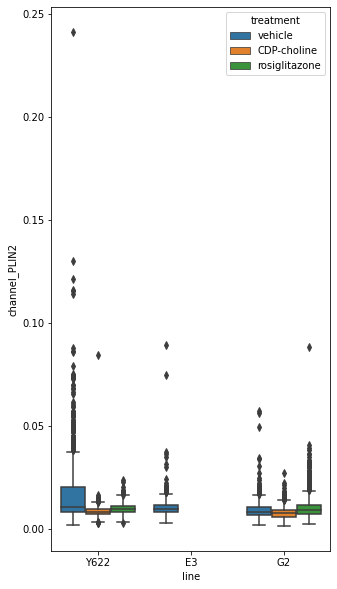

In [139]:
plt.figure(figsize=(5,10))
sns.boxplot(data=resE, x='line', y='channel_PLIN2', hue='treatment')

(array([6.000e+00, 7.100e+01, 6.680e+02, 3.629e+03, 1.944e+03, 2.730e+02,
        1.410e+02, 4.000e+01, 1.100e+01, 1.000e+00]),
 array([-9.68116577, -8.91808789, -8.15501001, -7.39193212, -6.62885424,
        -5.86577636, -5.10269848, -4.3396206 , -3.57654272, -2.81346484,
        -2.05038695]),
 <BarContainer object of 10 artists>)

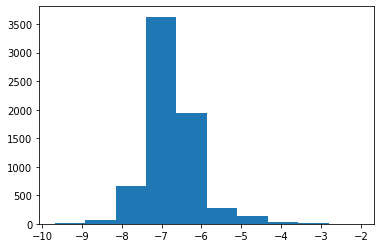

In [119]:
plt.hist(np.log2(resE['channel_PLIN2']))

<Axes: xlabel='channel_Lipidspot', ylabel='Count'>

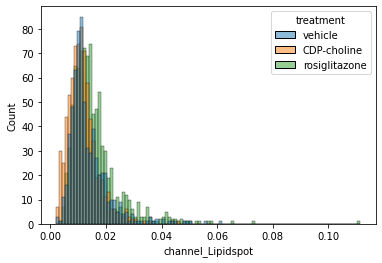

In [123]:
sns.histplot(data=resE[resE['line']=='G2'], x='channel_Lipidspot', hue='treatment')

<Axes: xlabel='channel_Lipidspot', ylabel='Density'>

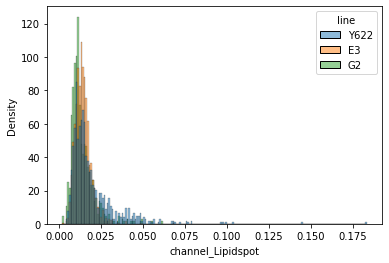

In [132]:
sns.histplot(data=resE[resE['treatment']=='vehicle'], x=('channel_Lipidspot'), hue='line', stat='density', common_norm=False)

In [121]:
2+2

4

<Axes: xlabel='channel_Lipidspot', ylabel='channel_PLIN2'>

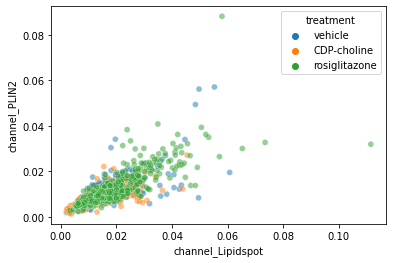

In [115]:
sns.scatterplot(data=resE[resE['line']=='G2'], x='channel_Lipidspot', y='channel_PLIN2', hue = 'treatment', alpha=.5)

In [104]:
resE.head()

,channel_DAPI,channel_NeuN,channel_Lipidspot,channel_PLIN2,ID,file,line,treatment,well,size
0,0.073882,0.007550,0.007474,0.009945,0,B03_1.czi,Y622,vehicle,B03_1.czi,20038.0
1,0.088154,0.011478,0.011948,0.012823,0,B03_1.czi,Y622,vehicle,B03_1.czi,16148.0
2,0.092628,0.014258,0.014191,0.017924,0,B03_1.czi,Y622,vehicle,B03_1.czi,19684.0
3,0.155061,0.016795,0.017816,0.027390,0,B03_1.czi,Y622,vehicle,B03_1.czi,14273.0
4,0.110614,0.017744,0.015508,0.022386,0,B03_1.czi,Y622,vehicle,B03_1.czi,15234.0


In [86]:
# get meta
def get_meta_vectors(in_parent, files):
    meta = pd.read_csv(in_parent + 'temp.csv')
    meta.columns = ['well', 'Treatment']
    meta['line'] = np.array([str(x).split(' ')[0] for x in meta['Treatment']])
    meta['treatment'] = np.array([str(x).split(' ')[1] if len(str(x).split(' '))>1 else np.nan for x in meta['Treatment']])
    meta['well'] = [x.split('-')[0] for x in meta['well']]

    dictionary = dict(zip(meta['well'], meta['line']))
    dictionary2 = dict(zip(meta['well'], meta['treatment']))

    lines = np.array([dictionary[x.split('_')[0]] for x in files])
    treat = np.array([dictionary2[x.split('_')[0]] for x in files])
    return lines, treat

@nb.njit(parallel=True)
def get_expectations(M_unique, masks_sele, probs_sele, vals_sele, E, V, N, thresh):
    """
    Calculate expectations, variance, and count for each unique mask value.

    Parameters:
    - M_unique (int): Number of unique mask values.
    - masks_sele (np.ndarray): Selected mask values.
    - probs_sele (np.ndarray): Probabilities associated with the mask values.
    - vals_sele (np.ndarray): Values associated with the mask values.
    - E (np.ndarray): Array to store expectations.
    - V (np.ndarray): Array to store variance.
    - N (np.ndarray): Array to store count.

    Returns:
    - None: Modifies the input arrays in-place.
    """
    for M in nb.prange(M_unique):
        index = masks_sele==M
        temp_probs = probs_sele[index]
        temp_vals = vals_sele[index]

        #E_uniform[M] = np.mean(temp_vals)
        P = temp_probs/np.sum(temp_probs)
        E[M] = np.dot(temp_vals, P)
        V[M] = np.dot((np.power((temp_vals-E[M]),2)), P)/E[M]
        N[M] = np.sum(index)
        F[M] = np.sum(temp_vals>thresh)/N[M]
        
def compute_intensities(channels, channel_names, files, zi_per_job, Nzi_per_job, probs, all_masks, all_mat, lines, treat):

    resE = []
    resV = []
    resN = []
    resF = []

    for ID in tqdm(range(len(files))):
        start = ID*zi_per_job
        end = start + Nzi_per_job[ID][0]

        probs_sele = probs[start:end].ravel()
        masks_sele = all_masks[start:end].ravel()
        out_float_sele = all_mat[start:end]

        M_unique = np.unique(masks_sele)
        NM = len(M_unique)

        outputs_E = np.empty((NM, len(channels)))
        outputs_V = np.empty((NM, len(channels)))
        outputs_N = np.empty((NM, len(channels)))
        outputs_F = np.empty((NM, len(channels)))

        E = np.empty(NM)
        V = np.empty(NM)
        N = np.empty(NM)
        F = np.empty(NM)

        for C in channels:
            vals_sele = out_float_sele[:,:,:,C].ravel()
            get_expectations(NM, masks_sele, probs_sele, vals_sele, E, V, N, thresh[C])
            outputs_E[:,C] = E
            outputs_V[:,C] = V
            outputs_N[:,C] = N
            outputs_F[:,C] = F

        df_E = pd.DataFrame(outputs_E[1:])
        df_E.columns = ['channel_' + str(i) for i in channel_names]
        df_E['ID'] = ID
        df_E['file'] = files[ID]
        df_E['line'] = lines[ID]
        df_E['treatment'] = treat[ID]

        df_V = pd.DataFrame(outputs_V[1:])
        df_V.columns = ['channel_' + str(i) for i in channel_names]
        df_V['ID'] = ID
        df_V['file'] = files[ID]
        df_V['line'] = lines[ID]
        df_V['treatment'] = treat[ID]

        df_N = pd.DataFrame(outputs_N[1:])

        resE.append(df_E)
        resV.append(df_V)
        resN.append(df_N)

    # concatenate the results

    resE = pd.concat(resE)
    resE['well'] = [x.split('-')[0] for x in resE['file']]
    resE.index = range(resE.shape[0])

    resV = pd.concat(resV)
    resV['well'] = [x.split('-')[0] for x in resV['file']]
    resV.index = range(resV.shape[0])

    resN = pd.concat(resN)
    resN.index = range(resN.shape[0])
    resE['size'] = resN[0]
                        
    return resV, resN, resE

In [82]:
len(files)

96

In [ ]:

# get line / treatment info



#### 3. Plot distributions